In [1]:
!pip install bert-for-tf2

In [2]:
import pandas as pd
import numpy as np
import json
import re
import os
import matplotlib.pyplot as plt
from tqdm import tqdm
from sklearn.metrics import accuracy_score, f1_score, recall_score, precision_score, confusion_matrix, roc_auc_score

In [3]:
import tensorflow as tf
import transformers
import bert 
from bert import BertModelLayer
from bert.loader import StockBertConfig, map_stock_config_to_params, load_stock_weights
from bert.tokenization.bert_tokenization import FullTokenizer 
from tensorflow import keras
from tensorflow.keras.layers import *
from tensorflow.keras.models import Model,Sequential
from keras.optimizers import Adam
from keras.utils.vis_utils import plot_model
from keras.callbacks import ModelCheckpoint

## Load Dataset

In [4]:
df_train = pd.read_csv('train.csv')
df_val = pd.read_csv('train.csv')
df_test = pd.read_csv('train.csv')

In [5]:
print(df_train.info())
df_train

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 31962 entries, 0 to 31961
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      31962 non-null  int64 
 1   label   31962 non-null  int64 
 2   tweet   31962 non-null  object
dtypes: int64(2), object(1)
memory usage: 749.2+ KB
None


,id,label,tweet
0,1,0,@user when a father is dysfunctional and is s...
1,2,0,@user @user thanks for #lyft credit i can't us...
2,3,0,bihday your majesty
3,4,0,#model i love u take with u all the time in ...
4,5,0,factsguide: society now #motivation
...,...,...,...
31957,31958,0,ate @user isz that youuu?ðððððð...
31958,31959,0,to see nina turner on the airwaves trying to...
31959,31960,0,listening to sad songs on a monday morning otw...
31960,31961,1,"@user #sikh #temple vandalised in in #calgary,..."


In [6]:
print(df_val.info())
df_val

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 31962 entries, 0 to 31961
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      31962 non-null  int64 
 1   label   31962 non-null  int64 
 2   tweet   31962 non-null  object
dtypes: int64(2), object(1)
memory usage: 749.2+ KB
None


,id,label,tweet
0,1,0,@user when a father is dysfunctional and is s...
1,2,0,@user @user thanks for #lyft credit i can't us...
2,3,0,bihday your majesty
3,4,0,#model i love u take with u all the time in ...
4,5,0,factsguide: society now #motivation
...,...,...,...
31957,31958,0,ate @user isz that youuu?ðððððð...
31958,31959,0,to see nina turner on the airwaves trying to...
31959,31960,0,listening to sad songs on a monday morning otw...
31960,31961,1,"@user #sikh #temple vandalised in in #calgary,..."


<AxesSubplot:xlabel='label', ylabel='count'>

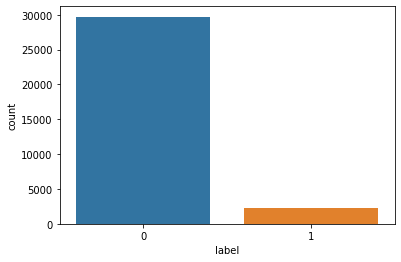

In [7]:
import seaborn as sns
sns.countplot(x="label", data = df_train)

In [8]:
print(df_test.info())
df_test

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 31962 entries, 0 to 31961
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      31962 non-null  int64 
 1   label   31962 non-null  int64 
 2   tweet   31962 non-null  object
dtypes: int64(2), object(1)
memory usage: 749.2+ KB
None


,id,label,tweet
0,1,0,@user when a father is dysfunctional and is s...
1,2,0,@user @user thanks for #lyft credit i can't us...
2,3,0,bihday your majesty
3,4,0,#model i love u take with u all the time in ...
4,5,0,factsguide: society now #motivation
...,...,...,...
31957,31958,0,ate @user isz that youuu?ðððððð...
31958,31959,0,to see nina turner on the airwaves trying to...
31959,31960,0,listening to sad songs on a monday morning otw...
31960,31961,1,"@user #sikh #temple vandalised in in #calgary,..."


## Metrics

In [9]:
def get_metrics(y_test, y_pred_proba):
    print('ACCURACY_SCORE: ', round(accuracy_score(y_test, y_pred_proba >= 0.5), 4))
    print('F1_SCORE: ', round(f1_score(y_test, y_pred_proba >= 0.5, average = "macro"), 4))
    print('ROC_AUC_SCORE: ', round(roc_auc_score(y_test, y_pred_proba), 4))
    print('CONFUSION_MATRIX:\n', confusion_matrix(y_test, y_pred_proba >= 0.5),'\n')

In [10]:
#Removes Punctuations
def remove_punctuations(data):
    punct_tag=re.compile(r'[^\w\s]')
    data=punct_tag.sub(r'',data)
    return data

#Removes HTML syntaxes
def remove_html(data):
    html_tag=re.compile(r'<.*?>')
    data=html_tag.sub(r'',data)
    return data

#Removes URL data
def remove_url(data):
    url_clean= re.compile(r"https://\S+|www\.\S+")
    data=url_clean.sub(r'',data)
    return data

#Removes Emojis
def remove_emoji(data):
    emoji_clean= re.compile("["
                           u"\U0001F600-\U0001F64F"  # emoticons
                           u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                           u"\U0001F680-\U0001F6FF"  # transport & map symbols
                           u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           u"\U00002702-\U000027B0"
                           u"\U000024C2-\U0001F251"
                           "]+", flags=re.UNICODE)
    data=emoji_clean.sub(r'',data)
    url_clean= re.compile(r"https://\S+|www\.\S+")
    data=url_clean.sub(r'',data)
    return data

df_train['tweet'] = df_train['tweet'].apply(lambda z: remove_punctuations(z))
df_train['tweet'] = df_train['tweet'].apply(lambda z: remove_html(z))
df_train['tweet'] = df_train['tweet'].apply(lambda z: remove_url(z))
df_train['tweet'] = df_train['tweet'].apply(lambda z: remove_emoji(z))

df_val['tweet'] = df_val['tweet'].apply(lambda z: remove_punctuations(z))
df_val['tweet'] = df_val['tweet'].apply(lambda z: remove_html(z))
df_val['tweet'] = df_val['tweet'].apply(lambda z: remove_url(z))
df_val['tweet'] = df_val['tweet'].apply(lambda z: remove_emoji(z))

df_test['tweet'] = df_test['tweet'].apply(lambda z: remove_punctuations(z))
df_test['tweet'] = df_test['tweet'].apply(lambda z: remove_html(z))
df_test['tweet'] = df_test['tweet'].apply(lambda z: remove_url(z))
df_test['tweet'] = df_test['tweet'].apply(lambda z: remove_emoji(z))

In [11]:
def remove_abb(data):
    data = re.sub(r"he's", "he is", data)
    data = re.sub(r"there's", "there is", data)
    data = re.sub(r"We're", "We are", data)
    data = re.sub(r"That's", "That is", data)
    data = re.sub(r"won't", "will not", data)
    data = re.sub(r"they're", "they are", data)
    data = re.sub(r"Can't", "Cannot", data)
    data = re.sub(r"wasn't", "was not", data)
    data = re.sub(r"don\x89Ûªt", "do not", data)
    data= re.sub(r"aren't", "are not", data)
    data = re.sub(r"isn't", "is not", data)
    data = re.sub(r"What's", "What is", data)
    data = re.sub(r"haven't", "have not", data)
    data = re.sub(r"hasn't", "has not", data)
    data = re.sub(r"There's", "There is", data)
    data = re.sub(r"He's", "He is", data)
    data = re.sub(r"It's", "It is", data)
    data = re.sub(r"You're", "You are", data)
    data = re.sub(r"I'M", "I am", data)
    data = re.sub(r"shouldn't", "should not", data)
    data = re.sub(r"wouldn't", "would not", data)
    data = re.sub(r"i'm", "I am", data)
    data = re.sub(r"I\x89Ûªm", "I am", data)
    data = re.sub(r"I'm", "I am", data)
    data = re.sub(r"Isn't", "is not", data)
    data = re.sub(r"Here's", "Here is", data)
    data = re.sub(r"you've", "you have", data)
    data = re.sub(r"you\x89Ûªve", "you have", data)
    data = re.sub(r"we're", "we are", data)
    data = re.sub(r"what's", "what is", data)
    data = re.sub(r"couldn't", "could not", data)
    data = re.sub(r"we've", "we have", data)
    data = re.sub(r"it\x89Ûªs", "it is", data)
    data = re.sub(r"doesn\x89Ûªt", "does not", data)
    data = re.sub(r"It\x89Ûªs", "It is", data)
    data = re.sub(r"Here\x89Ûªs", "Here is", data)
    data = re.sub(r"who's", "who is", data)
    data = re.sub(r"I\x89Ûªve", "I have", data)
    data = re.sub(r"y'all", "you all", data)
    data = re.sub(r"can\x89Ûªt", "cannot", data)
    data = re.sub(r"would've", "would have", data)
    data = re.sub(r"it'll", "it will", data)
    data = re.sub(r"we'll", "we will", data)
    data = re.sub(r"wouldn\x89Ûªt", "would not", data)
    data = re.sub(r"We've", "We have", data)
    data = re.sub(r"he'll", "he will", data)
    data = re.sub(r"Y'all", "You all", data)
    data = re.sub(r"Weren't", "Were not", data)
    data = re.sub(r"Didn't", "Did not", data)
    data = re.sub(r"they'll", "they will", data)
    data = re.sub(r"they'd", "they would", data)
    data = re.sub(r"DON'T", "DO NOT", data)
    data = re.sub(r"That\x89Ûªs", "That is", data)
    data = re.sub(r"they've", "they have", data)
    data = re.sub(r"i'd", "I would", data)
    data = re.sub(r"should've", "should have", data)
    data = re.sub(r"You\x89Ûªre", "You are", data)
    data = re.sub(r"where's", "where is", data)
    data = re.sub(r"Don\x89Ûªt", "Do not", data)
    data = re.sub(r"we'd", "we would", data)
    data = re.sub(r"i'll", "I will", data)
    data = re.sub(r"weren't", "were not", data)
    data = re.sub(r"They're", "They are", data)
    data = re.sub(r"Can\x89Ûªt", "Cannot", data)
    data = re.sub(r"you\x89Ûªll", "you will", data)
    data = re.sub(r"I\x89Ûªd", "I would", data)
    data = re.sub(r"let's", "let us", data)
    data = re.sub(r"it's", "it is", data)
    data = re.sub(r"can't", "cannot", data)
    data = re.sub(r"don't", "do not", data)
    data = re.sub(r"you're", "you are", data)
    data = re.sub(r"i've", "I have", data)
    data = re.sub(r"that's", "that is", data)
    data = re.sub(r"i'll", "I will", data)
    data = re.sub(r"doesn't", "does not",data)
    data = re.sub(r"i'd", "I would", data)
    data = re.sub(r"didn't", "did not", data)
    data = re.sub(r"ain't", "am not", data)
    data = re.sub(r"you'll", "you will", data)
    data = re.sub(r"I've", "I have", data)
    data = re.sub(r"Don't", "do not", data)
    data = re.sub(r"I'll", "I will", data)
    data = re.sub(r"I'd", "I would", data)
    data = re.sub(r"Let's", "Let us", data)
    data = re.sub(r"you'd", "You would", data)
    data = re.sub(r"It's", "It is", data)
    data = re.sub(r"Ain't", "am not", data)
    data = re.sub(r"Haven't", "Have not", data)
    data = re.sub(r"Could've", "Could have", data)
    data = re.sub(r"youve", "you have", data)  
    data = re.sub(r"donå«t", "do not", data)  
    return data
    
df_train['tweet'] = df_train['tweet'].apply(lambda z: remove_abb(z))
df_val['tweet'] = df_val['tweet'].apply(lambda z: remove_abb(z))
df_test['tweet'] = df_test['tweet'].apply(lambda z: remove_abb(z))

In [12]:
print(df_train.shape)
print(df_train.head(5))
print(df_val.shape)
print(df_val.head(5))
print(df_test.shape)
print(df_test.head(5))

(31962, 3)
   id  label                                              tweet
0   1      0   user when a father is dysfunctional and is so...
1   2      0  user user thanks for lyft credit i cant use ca...
2   3      0                                bihday your majesty
3   4      0  model   i love u take with u all the time in u...
4   5      0               factsguide society now    motivation
(31962, 3)
   id  label                                              tweet
0   1      0   user when a father is dysfunctional and is so...
1   2      0  user user thanks for lyft credit i cant use ca...
2   3      0                                bihday your majesty
3   4      0  model   i love u take with u all the time in u...
4   5      0               factsguide society now    motivation
(31962, 3)
   id  label                                              tweet
0   1      0   user when a father is dysfunctional and is so...
1   2      0  user user thanks for lyft credit i cant use ca...
2   3  

## Encoding 

In [13]:
class IntentDetectionData:
    DATA_COLUMN,  LABEL_COLUMN  = "tweet","label"

    def __init__(self, train, val, test, tokenizer: FullTokenizer, classes, max_seq_len):
        self.tokenizer = tokenizer
        self.max_seq_len = 0
        self.classes = classes

        ((self.train_x, self.train_y), (self.val_x, self.val_y), (self.test_x, self.test_y)) = map(self._prepare, [train, val, test])

        self.max_seq_len = min(self.max_seq_len, max_seq_len)
        self.train_x, self.val_x, self.test_x = map(self._pad, [self.train_x, self.val_x, self.test_x])

    def _prepare(self, df):
        x, y = [], []
    
        for non, row in tqdm(df.iterrows()):
            text, label =\
                row[IntentDetectionData.DATA_COLUMN], row[IntentDetectionData.LABEL_COLUMN]

            tokens = self.tokenizer.tokenize(text)
            tokens = ["[CLS]"] + tokens + ["[SEP]"] ## Tokens beigning and ending specified by separation of tokens.

            token_ids = self.tokenizer.convert_tokens_to_ids(tokens) ## Convert Tokens to IDs

            self.max_seq_len = max(self.max_seq_len, len(token_ids))

            x.append(token_ids)
            y.append(self.classes.index(label))

        return np.array(x), np.array(y)

    def _pad(self, ids):
        x = []
        for input_ids in ids:
            input_ids = input_ids[:min(len(input_ids), self.max_seq_len - 2)] ## -2 as ignoring tokens provided by bert
            input_ids = input_ids + [0] * (self.max_seq_len - len(input_ids)) ## padding by zeros
            x.append(np.array(input_ids))
        
        return np.array(x)

## Model

### CNN

In [14]:
def CNN_V0(bert_output):
    net = Conv1D(128, 7, activation='relu',padding='same')(bert_output)
    net = MaxPooling1D()(net)
    net = Conv1D(256, 5, activation='relu',padding='same')(net)
    net = MaxPooling1D()(net)
    net = Conv1D(512, 3, activation='relu',padding='same')(net)
    net = MaxPooling1D()(net)
    net = Flatten()(net)
    net = Dense(128, activation='relu')(net)
    net = Dropout(0.5)(net)
    outputs = Dense(1, activation='sigmoid', name='classifier')(net) 
    return outputs

### BiLSTM

In [15]:
def BiLSTM_V0(bert_output):
    net = Bidirectional(LSTM(units=32, return_sequences=True,))(bert_output)
    net = GlobalAveragePooling1D()(net)
    net = Dense(20, activation='relu')(net)
    net = Dropout(rate=0.5)(net)
    outputs = Dense(1, activation='sigmoid', name='classifier')(net) 
    return outputs

In [16]:
def LSTM_V0(bert_output):
    net = LSTM(units=32, return_sequences=True,)(bert_output)
    net = GlobalAveragePooling1D()(net)
    net = Dense(20, activation='relu')(net)
    net = Dropout(rate=0.5)(net)
    outputs = Dense(1, activation='sigmoid', name='classifier')(net) 
    return outputs

### CNN + LSTM

In [17]:
def CNN_LSTM_V0(bert_output):
    net = Dropout(0.3)(bert_output)
    net = Conv1D(200, 5, activation='relu')(net)
    net = MaxPooling1D(pool_size=2)(net)
    net = LSTM(100)(net)
    net = Dropout(0.3)(net)
    net = Dense(16,activation='relu')(net)
    outputs = Dense(1, activation='sigmoid', name='classifier')(net)
    return outputs

In [18]:
def CNN_LSTM_V1(bert_output):

    # channel 1
    net = Conv1D(filters=128, kernel_size=3*32, activation='relu')(bert_output)
    net = MaxPooling1D(pool_size=2)(net)
    net = Dropout(0.5)(net)
    net = BatchNormalization()(net)
    a = LSTM(128)(net)

    # channel 2
    net = Conv1D(filters=128, kernel_size=5*32, activation='relu')(bert_output)
    net = MaxPooling1D(pool_size=2)(net)
    net = Dropout(0.5)(net)
    net = BatchNormalization()(net)
    b = LSTM(128)(net)

    # channel 3
    net = Conv1D(filters=128, kernel_size=7*32, activation='relu')(bert_output)
    net = MaxPooling1D(pool_size=2)(net)
    net = Dropout(0.5)(net)
    net = BatchNormalization()(net)
    c = LSTM(128)(net)

    # channel 4
    net = Conv1D(filters=128, kernel_size=9*32, activation='relu')(bert_output)
    net = MaxPooling1D(pool_size=2)(net)
    net = Dropout(0.5)(net)
    net = BatchNormalization()(net)
    d = LSTM(128)(net)

    merged = concatenate([a,b,c,d])
    dense = Dense(100, activation='relu')(merged)
    drop = Dropout(0.2)(dense)
    outputs = Dense(1, activation='sigmoid')(merged)
    return outputs

### LSTM + CNN

In [19]:
def LSTM_CNN_V0(bert_output):
    net = Bidirectional(LSTM(128, return_sequences=True))(bert_output)
    net = Conv1D(128, 7, activation='relu',padding='same')(net)
    net = MaxPooling1D()(net)
    net = Conv1D(256, 5, activation='relu',padding='same')(net)
    net = MaxPooling1D()(net)
    net = Conv1D(512, 3, activation='relu',padding='same')(net)
    net = MaxPooling1D()(net)
    net = Flatten()(net)
    net = Dense(128, activation='relu')(net)
    net = Dropout(0.5)(net)
    outputs = Dense(1, activation='sigmoid', name='classifier')(net) 
    return outputs

In [20]:
def create_model(model_name, model_ver, max_seq_len, bert_checkpnt_file):

    with tf.io.gfile.GFile(bert_config_file, "r") as reader:
        bc = StockBertConfig.from_json_string(reader.read()) ## Reading bert config
        bert_params = map_stock_config_to_params(bc) ## Mapping parameters 
        bert_params.adapter_size = None # Adapter size helps tune Bert model faster
        bert = BertModelLayer.from_params(bert_params, name="bert")
        
    ## Creat dictionary
    choose_model = {'CNN':{0: CNN_V0},
                    'BiLSTM':{0: BiLSTM_V0},
                    'LSTM':{0: LSTM_V0},
                    'CNN+LSTM':{0: CNN_LSTM_V0, 1: CNN_LSTM_V1},
                    'LSTM+CNN':{0: LSTM_CNN_V0},}
    
    ## Specifying input
    input_ids = keras.layers.Input(shape=(max_seq_len,), dtype='int32', name="input_ids")
    bert_output = bert(input_ids)
        
    outputs = choose_model[model_name][model_ver](bert_output)

    model = keras.Model(input_ids, outputs)
    model.build(input_shape=(None, max_seq_len))
    load_stock_weights(bert, bert_checkpnt_file) ##Loading the weights from bert chckpoint file
        
    return model

## BERT GCN

In [21]:
bert_model_name = "uncased_L-12_H-768_A-12"
# uncased_L-4_H-512_A-8
# uncased_L-12_H-768_A-12

#!wget  https://storage.googleapis.com/bert_models/2020_02_20/uncased_L-12_H-768_A-12.zip
#!unzip {bert_model_name}.zip

In [22]:
bert_model_path = "./"
bert_checkpnt_file = os.path.join(bert_model_path, "bert_model.ckpt")
bert_config_file = os.path.join(bert_model_path, "bert_config.json")
bert_vocab_file = os.path.join(bert_model_path, "vocab.txt")
print(bert_checkpnt_file)
print(bert_config_file)
print(bert_vocab_file)

./bert_model.ckpt
./bert_config.json
./vocab.txt


## Data Pretrain

In [23]:
# Tokenize
tokenizer = FullTokenizer(vocab_file=bert_vocab_file)
tokens = tokenizer.tokenize("People say nothing is impossible, but I do nothing everyday")
print(tokens)
tokenizer.convert_tokens_to_ids(tokens)

['people', 'say', 'nothing', 'is', 'impossible', ',', 'but', 'i', 'do', 'nothing', 'everyday']


[2111, 2360, 2498, 2003, 5263, 1010, 2021, 1045, 2079, 2498, 10126]

In [24]:
classes = [0, 1]
max_seq_len = 72
data = IntentDetectionData(df_train, df_val, df_test, tokenizer, classes, max_seq_len)
print(data.max_seq_len)

31962it [00:10, 3177.33it/s]
31962it [00:09, 3447.36it/s]
31962it [00:09, 3377.92it/s]


72


## GCN - NN with BERT

In [26]:
model_name = "CNN"
model_ver = 0
LR = 2e-5
loss = tf.keras.losses.BinaryCrossentropy(from_logits=True)
optimizer = Adam(learning_rate=LR)
metrics = tf.metrics.BinaryAccuracy()

model = create_model(model_name, model_ver, max_seq_len, bert_checkpnt_file)
model.compile(loss=loss, optimizer=optimizer, metrics=metrics)
model.summary()

Done loading 196 BERT weights from: ./bert_model.ckpt into <bert.model.BertModelLayer object at 0x000002CBF2B86910> (prefix:bert). Count of weights not found in the checkpoint was: [0]. Count of weights with mismatched shape: [0]
Unused weights from checkpoint: 
	bert/embeddings/token_type_embeddings
	bert/pooler/dense/bias
	bert/pooler/dense/kernel
	cls/predictions/output_bias
	cls/predictions/transform/LayerNorm/beta
	cls/predictions/transform/LayerNorm/gamma
	cls/predictions/transform/dense/bias
	cls/predictions/transform/dense/kernel
	cls/seq_relationship/output_bias
	cls/seq_relationship/output_weights
Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_ids (InputLayer)       [(None, 72)]              0         
_________________________________________________________________
bert (BertModelLayer)        (None, 72, 768)           108890112 
_________________________________

## Model training

In [28]:
# Save model
model_ckpt_path = f"[{bert_model_name}]{model_name}_V{model_ver}_{max_seq_len}.hdf5"
checkpoint = ModelCheckpoint(model_ckpt_path, monitor='val_binary_accuracy', mode='max',verbose=1, save_best_only=True, save_weights_only=True)
callbacks_list = [checkpoint]

# Training
print(f"Training model with {bert_model_name}_{model_name}_V{model_ver}_{max_seq_len}\n")
train_history = model.fit(data.train_x, data.train_y, validation_data=(data.val_x,data.val_y), epochs=2, batch_size=16, verbose=1, callbacks=callbacks_list)

Training model with uncased_L-12_H-768_A-12_CNN_V0_72

Epoch 1/2
1998/1998 [==============================] - ETA: 0s - loss: 0.6931 - binary_accuracy: 0.9299
Epoch 00001: val_binary_accuracy improved from -inf to 0.92985, saving model to [uncased_L-12_H-768_A-12]CNN_V0_72.hdf5
1998/1998 [==============================] - 22234s 11s/step - loss: 0.6931 - binary_accuracy: 0.9299 - val_loss: 0.6931 - val_binary_accuracy: 0.9299
Epoch 2/2
1998/1998 [==============================] - ETA: 0s - loss: 0.6931 - binary_accuracy: 0.9299
Epoch 00002: val_binary_accuracy did not improve from 0.92985
1998/1998 [==============================] - 22702s 11s/step - loss: 0.6931 - binary_accuracy: 0.9299 - val_loss: 0.6931 - val_binary_accuracy: 0.9299


dict_keys(['loss', 'binary_accuracy', 'val_loss', 'val_binary_accuracy'])


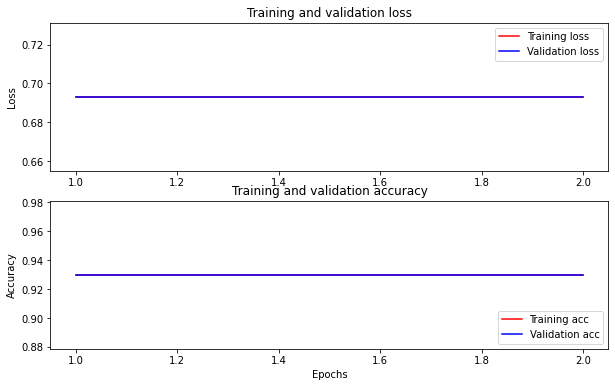

In [29]:
# Plot accuracy and loss
history_dict = train_history.history
print(history_dict.keys())

acc = history_dict['binary_accuracy']
val_acc = history_dict['val_binary_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)
fig = plt.figure(figsize=(10, 6))
fig.tight_layout()

plt.subplot(2, 1, 1)
plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.ylabel('Loss')
plt.legend()

plt.subplot(2, 1, 2)
plt.plot(epochs, acc, 'r', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')

In [30]:
# Save architecture model
config = model.to_json()
model_config_path = f"[{bert_model_name}]{model_name}_V{model_ver}_{max_seq_len}.json"
with open(model_config_path, "w") as outfile:
    json.dump(config, outfile)

## Evaluate

In [31]:
model.load_weights(model_ckpt_path)
y_pred_proba = model.predict(data.test_x)
get_metrics(data.test_y, y_pred_proba)

ACCURACY_SCORE:  0.9299
F1_SCORE:  0.4818
ROC_AUC_SCORE:  0.5564
CONFUSION_MATRIX:
 [[29720     0]
 [ 2242     0]] 



# LSTM + GCN with BERT

In [25]:
model_name = "LSTM"
model_ver = 0
LR = 2e-5
loss = tf.keras.losses.BinaryCrossentropy(from_logits=True)
optimizer = Adam(learning_rate=LR)
metrics = tf.metrics.BinaryAccuracy()

model = create_model(model_name, model_ver, max_seq_len, bert_checkpnt_file)
model.compile(loss=loss, optimizer=optimizer, metrics=metrics)
model.summary()

Done loading 196 BERT weights from: ./bert_model.ckpt into <bert.model.BertModelLayer object at 0x00000181693A02B0> (prefix:bert). Count of weights not found in the checkpoint was: [0]. Count of weights with mismatched shape: [0]
Unused weights from checkpoint: 
	bert/embeddings/token_type_embeddings
	bert/pooler/dense/bias
	bert/pooler/dense/kernel
	cls/predictions/output_bias
	cls/predictions/transform/LayerNorm/beta
	cls/predictions/transform/LayerNorm/gamma
	cls/predictions/transform/dense/bias
	cls/predictions/transform/dense/kernel
	cls/seq_relationship/output_bias
	cls/seq_relationship/output_weights
Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_ids (InputLayer)       [(None, 72)]              0         
_________________________________________________________________
bert (BertModelLayer)        (None, 72, 768)           108890112 
_________________________________

In [28]:
# Save model
model_ckpt_path = f"[{bert_model_name}]{model_name}_V{model_ver}_{max_seq_len}.hdf5"
checkpoint = ModelCheckpoint(model_ckpt_path, monitor='val_binary_accuracy', mode='max',verbose=1, save_best_only=True, save_weights_only=True)
callbacks_list = [checkpoint]

# Training
print(f"Training model with {bert_model_name}_{model_name}_V{model_ver}_{max_seq_len}\n")
train_history = model.fit(data.train_x, data.train_y, validation_data=(data.val_x,data.val_y), epochs=3, batch_size=16, verbose=1, callbacks=callbacks_list)

Training model with uncased_L-12_H-768_A-12_LSTM_V0_72

Epoch 1/3
1998/1998 [==============================] - ETA: 0s - loss: 0.7506 - binary_accuracy: 0.9259
Epoch 00001: val_binary_accuracy improved from -inf to 0.92985, saving model to [uncased_L-12_H-768_A-12]LSTM_V0_72.hdf5
1998/1998 [==============================] - 22392s 11s/step - loss: 0.7506 - binary_accuracy: 0.9259 - val_loss: 0.7011 - val_binary_accuracy: 0.9299
Epoch 2/3
1998/1998 [==============================] - ETA: 0s - loss: 0.7186 - binary_accuracy: 0.9289
Epoch 00002: val_binary_accuracy did not improve from 0.92985
1998/1998 [==============================] - 22334s 11s/step - loss: 0.7186 - binary_accuracy: 0.9289 - val_loss: 0.6943 - val_binary_accuracy: 0.9299
Epoch 3/3
1998/1998 [==============================] - ETA: 0s - loss: 0.7107 - binary_accuracy: 0.9299
Epoch 00003: val_binary_accuracy did not improve from 0.92985
1998/1998 [==============================] - 21285s 11s/step - loss: 0.7107 - binary_

dict_keys(['loss', 'binary_accuracy', 'val_loss', 'val_binary_accuracy'])


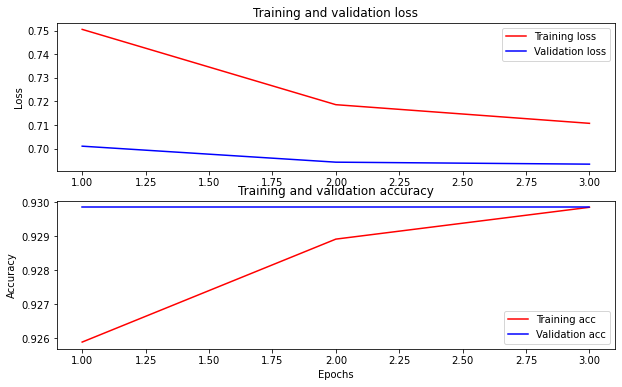

In [29]:
# Plot accuracy and loss
history_dict = train_history.history
print(history_dict.keys())

acc = history_dict['binary_accuracy']
val_acc = history_dict['val_binary_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)
fig = plt.figure(figsize=(10, 6))
fig.tight_layout()

plt.subplot(2, 1, 1)
plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.ylabel('Loss')
plt.legend()

plt.subplot(2, 1, 2)
plt.plot(epochs, acc, 'r', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')

In [31]:
!pip install keras-tuner

In [32]:
#importing libraries for model evaluation and algorithms
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
import collections
import nltk
from sklearn import preprocessing
from nltk.tokenize import sent_tokenize, word_tokenize
# Packages for data preparation
from sklearn.model_selection import train_test_split
from nltk.corpus import stopwords
from keras.preprocessing.text import Tokenizer
from keras.utils.np_utils import to_categorical
from sklearn.preprocessing import LabelEncoder
#dl libraraies
import keras
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D , MaxPool2D , Flatten , Dropout , BatchNormalization,Reshape,Dot,Concatenate,Add,Lambda
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ReduceLROnPlateau
import cv2
from tensorflow.keras.optimizers import Adam,SGD,Adagrad,Adadelta,RMSprop
import os
from tensorflow.keras.models import Model
from tensorflow.keras.regularizers import l2
from keras.layers.recurrent import LSTM
from keras.preprocessing.sequence import pad_sequences
# specifically for deeplearning.
from tensorflow.keras.layers import Dropout, Flatten,Activation,Input,Embedding
from tensorflow.keras.layers import Conv2D, MaxPooling2D, BatchNormalization
# Packages for modeling
from keras import models
from keras import layers
from keras import regularizers
from kerastuner import RandomSearch
from kerastuner.engine.hyperparameters import HyperParameters

<ipython-input-32-2b705b9d0bdb>:38: DeprecationWarning: `import kerastuner` is deprecated, please use `import keras_tuner`.
  from kerastuner import RandomSearch


In [33]:
#reading the dataframe
df=pd.read_csv('train.csv')
df.head()

,id,label,tweet
0,1,0,@user when a father is dysfunctional and is s...
1,2,0,@user @user thanks for #lyft credit i can't us...
2,3,0,bihday your majesty
3,4,0,#model i love u take with u all the time in ...
4,5,0,factsguide: society now #motivation


In [34]:
#Setting parameters which will be used throughout
num_words = 15000  # Parameter indicating the number of words we'll put in the dictionary
val_size = 1000  # Size of the validation set
epochs = 20  # Number of epochs we usually start to train with
batch_size = 512  # Size of the batches used in the mini-batch gradient descent
#Taking only two columns since it's a sentiment analysis

In [35]:
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('averaged_perceptron_tagger')

[nltk_data] Downloading package punkt to C:\Users\Tru
[nltk_data]     Projects\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to C:\Users\Tru
[nltk_data]     Projects\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to C:\Users\Tru
[nltk_data]     Projects\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\Tru Projects\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping taggers\averaged_perceptron_tagger.zip.


True

In [36]:
#tweets conssits of every document as an array of tokenized words which are later appended to docs 
tweets=[word_tokenize(tweet) for tweet in df['tweet']]
docs=[]
for j in range(0,len(tweets)):
    docs.append(tweets[j])

In [37]:
#stops included both the stopwords and punctuations
from nltk.corpus import stopwords
import string
stops = set(stopwords.words('english'))
punctuations = list(string.punctuation)
not_list = ["n't", "not", "no"]
stops.update(punctuations)
stops.update(not_list)

In [38]:
#to get the simple pos(part of speech) tag
from nltk.corpus import wordnet
def get_simple_pos(tag):
    if tag.startswith('J'):
        return wordnet.ADJ
    elif tag.startswith('V'):
        return wordnet.VERB
    elif tag.startswith('N'):
        return wordnet.NOUN
    elif tag.startswith('R'):
        return wordnet.ADV
    else:
        return wordnet.NOUN

In [39]:
#to get the pos tag for a word
from nltk import pos_tag
# now we are going to clean our data 
# we will remove stopwords and punctuations and lemmatize each document
from nltk.stem import WordNetLemmatizer
lemmatizer=WordNetLemmatizer()
def clean(words):
    output=[]
    for word in words:
        if word.lower() not in stops or word.lower() in not_list:
            pos=pos_tag(word)
            clean_word=lemmatizer.lemmatize(word,pos=get_simple_pos(pos[0][1]))
            output.append(clean_word.lower())
    str1=" ".join(output).encode('utf-8')        
    return str1
#docs=[ clean(doc) for doc in docs]      

In [40]:
df=df[['tweet','label']]
df.head()

,tweet,label
0,@user when a father is dysfunctional and is s...,0
1,@user @user thanks for #lyft credit i can't us...,0
2,bihday your majesty,0
3,#model i love u take with u all the time in ...,0
4,factsguide: society now #motivation,0


In [41]:
#taking variables to be used for train test split as X,y
X,Y=df['tweet'].values,pd.get_dummies(df.label.values)

In [42]:
#using tokenizers to create the tokens having no of words=15000(num_words)
tk = Tokenizer(num_words=num_words,
               filters='!"#$%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n',
               lower=True,
               split=" ")
#Complete data is tokenized to vectors and padding is done using zeros to match its length to the largest text in the dataset.
tk.fit_on_texts(X)
X = tk.texts_to_sequences(X)
X = pad_sequences(X)
#print(X[:2])
print('Fitted tokenizer on {} documents'.format(tk.document_count))
print('{} words in dictionary'.format(tk.num_words))
print('Top 5 most common words are:', collections.Counter(tk.word_counts).most_common(5))

Fitted tokenizer on 31962 documents
15000 words in dictionary
Top 5 most common words are: [('user', 17577), ('the', 10165), ('to', 9833), ('a', 6481), ('i', 6170)]


In [43]:
import pickle
pickle.dump(tk,open('transform2.pkl','wb'))
#files.download('transform2.pkl')

In [44]:
#train test split
X_train, X_test, Y_train, Y_test = train_test_split(X,Y, test_size=0.2, random_state=42)
print('# Train data samples:', X_train.shape)
print('# Test data samples:', X_test.shape)

# Train data samples: (25569, 39)
# Test data samples: (6393, 39)


In [45]:
#getting validation data as a part of training data
X_train_rest, X_valid, Y_train_rest, Y_valid = train_test_split(X_train,Y_train, test_size=0.1, random_state=37)
print('Shape of validation set:',X_valid.shape)

Shape of validation set: (2557, 39)


In [46]:
#Function defined to test the models in the test set
def test_model(model, epoch_stop):
    model.fit(X_test
              , Y_test
              , epochs=epoch_stop
              , batch_size=batch_size
              , verbose=0)
    results = model.evaluate(X_test, Y_test)
    
    return results

# LSTM

In [47]:
embed_dim = 128 #dimension of the word embedding vector for each word in a sequence 
lstm_out = 196  #no of lstm layers
lstm_model = Sequential()
lstm_model.add(Embedding(num_words, embed_dim,input_length = X_train.shape[1]))
#Adding dropout
lstm_model.add(LSTM(lstm_out, dropout=0.2, recurrent_dropout=0.2))
#Adding a regularized dense layer
lstm_model.add(layers.Dense(32,kernel_regularizer=regularizers.l2(0.001),activation='relu'))
lstm_model.add(layers.Dropout(0.5))
lstm_model.add(Dense(2,activation='softmax'))
lstm_model.compile(loss = 'categorical_crossentropy', optimizer='adam',metrics = ['accuracy'])
print(lstm_model.summary())

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 39, 128)           1920000   
_________________________________________________________________
lstm_1 (LSTM)                (None, 196)               254800    
_________________________________________________________________
dense_1 (Dense)              (None, 32)                6304      
_________________________________________________________________
dropout_1 (Dropout)          (None, 32)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 2)                 66        
Total params: 2,181,170
Trainable params: 2,181,170
Non-trainable params: 0
_________________________________________________________________
None


In [48]:
#model trained on the training data and taking validation data into account to avoid overfitting for 4 epochs 
history_LSTM=lstm_model.fit(X_train_rest, Y_train_rest, epochs = 20, batch_size=batch_size,validation_data=(X_valid, Y_valid),verbose = 1)

Epoch 1/20
45/45 [==============================] - 25s 566ms/step - loss: 0.3685 - accuracy: 0.9170 - val_loss: 0.2697 - val_accuracy: 0.9308
Epoch 2/20
45/45 [==============================] - 24s 537ms/step - loss: 0.2063 - accuracy: 0.9438 - val_loss: 0.1432 - val_accuracy: 0.9589
Epoch 3/20
45/45 [==============================] - 25s 548ms/step - loss: 0.1105 - accuracy: 0.9729 - val_loss: 0.1307 - val_accuracy: 0.9632
Epoch 4/20
45/45 [==============================] - 25s 553ms/step - loss: 0.0721 - accuracy: 0.9834 - val_loss: 0.1429 - val_accuracy: 0.9664
Epoch 5/20
45/45 [==============================] - 25s 557ms/step - loss: 0.0531 - accuracy: 0.9884 - val_loss: 0.1495 - val_accuracy: 0.9554
Epoch 6/20
45/45 [==============================] - 25s 557ms/step - loss: 0.0396 - accuracy: 0.9928 - val_loss: 0.1651 - val_accuracy: 0.9593
Epoch 7/20
45/45 [==============================] - 26s 575ms/step - loss: 0.0294 - accuracy: 0.9953 - val_loss: 0.1946 - val_accuracy: 0.9539

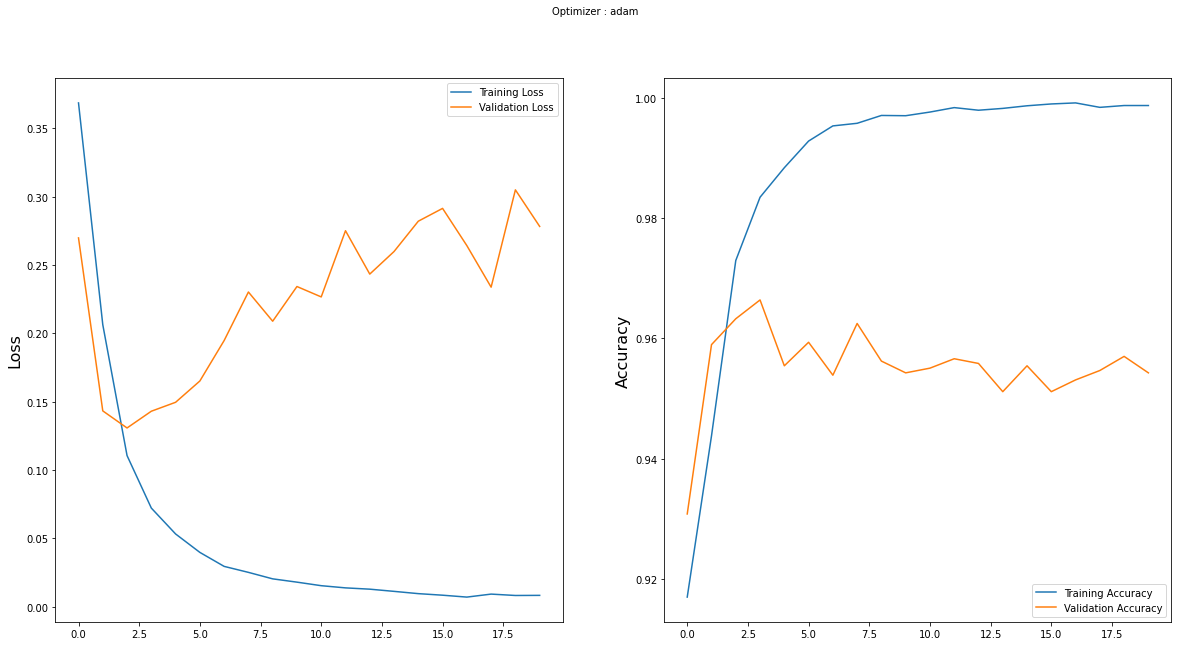

In [53]:
import matplotlib.pyplot as plt

x=history_LSTM
plt.figure(figsize=(20,10))
plt.subplot(1, 2, 1)
plt.suptitle('Optimizer : adam', fontsize=10)
plt.ylabel('Loss', fontsize=16)
plt.plot(x.history['loss'], label='Training Loss')
plt.plot(x.history['val_loss'], label='Validation Loss')
plt.legend(loc='upper right')

plt.subplot(1, 2, 2)
plt.ylabel('Accuracy', fontsize=16)
plt.plot(x.history['accuracy'], label='Training Accuracy')
plt.plot(x.history['val_accuracy'], label='Validation Accuracy')
plt.legend(loc='lower right')
plt.show()

In [49]:
#prediction by our lstm model on the test dataset
lstm_results = test_model(lstm_model, 3)
print('/n')
print('Test accuracy of lstm model: {0:.2f}%'.format(lstm_results[1]*100))

200/200 [==============================] - 2s 10ms/step - loss: 0.0349 - accuracy: 0.9900
/n
Test accuracy of lstm model: 99.00%


In [50]:
lstm_model.save('lstm_model.h5')

# GRU

In [51]:
from tensorflow.keras.layers import GRU, Dense, Embedding, Dropout

In [52]:
embed_dim = 128
gru_model = Sequential()
gru_model.add(Embedding(num_words, embed_dim,input_length = X_train.shape[1]))
gru_model.add(GRU(128, return_sequences=False))
gru_model.add(Dropout(0.5))
gru_model.add(Dense(2, activation = 'sigmoid'))
gru_model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
print(gru_model.summary())

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 39, 128)           1920000   
_________________________________________________________________
gru (GRU)                    (None, 128)               99072     
_________________________________________________________________
dropout_2 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 2)                 258       
Total params: 2,019,330
Trainable params: 2,019,330
Non-trainable params: 0
_________________________________________________________________
None


In [54]:
#model trained on the training data and taking validation data into account to avoid overfitting for 4 epochs 
history_GRU=gru_model.fit(X_train_rest, Y_train_rest, epochs = 20, batch_size=batch_size,validation_data=(X_valid, Y_valid),verbose = 1)

Epoch 1/20
45/45 [==============================] - 10s 215ms/step - loss: 0.3635 - accuracy: 0.9174 - val_loss: 0.2014 - val_accuracy: 0.9316
Epoch 2/20
45/45 [==============================] - 10s 214ms/step - loss: 0.1468 - accuracy: 0.9463 - val_loss: 0.1210 - val_accuracy: 0.9542
Epoch 3/20
45/45 [==============================] - 9s 205ms/step - loss: 0.0755 - accuracy: 0.9735 - val_loss: 0.1055 - val_accuracy: 0.9589
Epoch 4/20
45/45 [==============================] - 9s 209ms/step - loss: 0.0467 - accuracy: 0.9849 - val_loss: 0.1152 - val_accuracy: 0.9597
Epoch 5/20
45/45 [==============================] - 9s 204ms/step - loss: 0.0295 - accuracy: 0.9905 - val_loss: 0.1283 - val_accuracy: 0.9566
Epoch 6/20
45/45 [==============================] - 9s 201ms/step - loss: 0.0207 - accuracy: 0.9940 - val_loss: 0.1444 - val_accuracy: 0.9578
Epoch 7/20
45/45 [==============================] - 9s 200ms/step - loss: 0.0144 - accuracy: 0.9960 - val_loss: 0.1714 - val_accuracy: 0.9523
Epoc

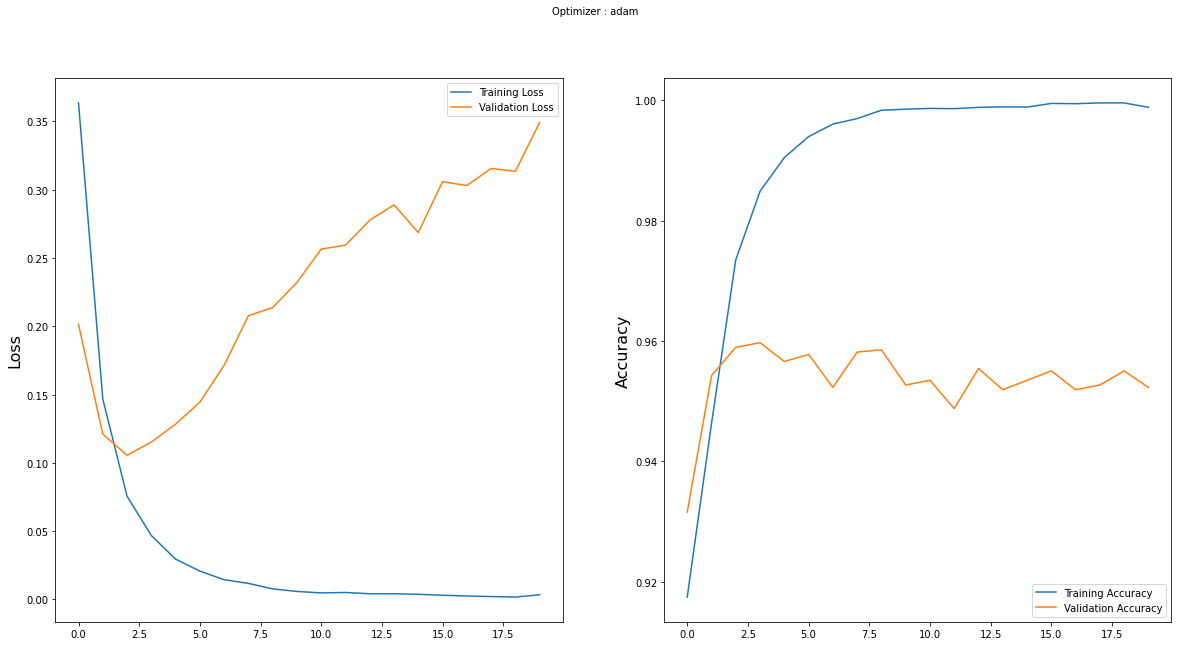

In [55]:
import matplotlib.pyplot as plt

x=history_GRU
plt.figure(figsize=(20,10))
plt.subplot(1, 2, 1)
plt.suptitle('Optimizer : adam', fontsize=10)
plt.ylabel('Loss', fontsize=16)
plt.plot(x.history['loss'], label='Training Loss')
plt.plot(x.history['val_loss'], label='Validation Loss')
plt.legend(loc='upper right')

plt.subplot(1, 2, 2)
plt.ylabel('Accuracy', fontsize=16)
plt.plot(x.history['accuracy'], label='Training Accuracy')
plt.plot(x.history['val_accuracy'], label='Validation Accuracy')
plt.legend(loc='lower right')
plt.show()

In [56]:
#prediction by our lstm model on the test dataset
gru_results = test_model(gru_model, 3)
print('/n')
print('Test accuracy of gru model: {0:.2f}%'.format(gru_results[1]*100))

200/200 [==============================] - 1s 5ms/step - loss: 0.0267 - accuracy: 0.9928
/n
Test accuracy of gru model: 99.28%


# FOR RNN

In [72]:
num_classes = df.label.nunique()
print(num_classes)

2


In [73]:
def cleaning_text(text):
    stop_words = stopwords.words("english")

    text = re.sub(r'http\S+', " ", text)    # remove urls
    text = re.sub(r'@\w+',' ',text)         # remove mentions
    text = re.sub(r'#\w+', ' ', text)       # remove hastags
    text = re.sub('r<.*?>',' ', text)       # remove html tags
    
    # remove stopwords 
    text = text.split()
    text = " ".join([word for word in text if not word in stop_words])

    for punctuation in string.punctuation:
        text = text.replace(punctuation, "")
    
    return text

In [74]:
df['tweet'] = df['tweet'].apply(lambda x: cleaning_text(x))

In [76]:
# Maximum sentence length
max_len_words = max(list(df['tweet'].apply(len)))
print(max_len_words)

246


In [77]:
def tokenizer(x_train, y_train, max_len_word):
    # because the data distribution is imbalanced, "stratify" is used
    X_train, X_val, y_train, y_val = train_test_split(x_train, y_train, 
                                                      test_size=.2, shuffle=True, 
                                                      stratify=y_train, random_state=0)

    # Tokenizer
    tokenizer = Tokenizer(num_words=5000)
    tokenizer.fit_on_texts(X_train)
    sequence_dict = tokenizer.word_index
    word_dict = dict((num, val) for (val, num) in sequence_dict.items())

    # Sequence data
    train_sequences = tokenizer.texts_to_sequences(X_train)
    train_padded = pad_sequences(train_sequences,
                                 maxlen=max_len_word,
                                 truncating='post',
                                 padding='post')
    
    val_sequences = tokenizer.texts_to_sequences(X_val)
    val_padded = pad_sequences(val_sequences,
                                maxlen=max_len_word,
                                truncating='post',
                                padding='post', )
    
    print(train_padded.shape)
    print(val_padded.shape)
    print('Total words: {}'.format(len(word_dict)))
    return train_padded, val_padded, y_train, y_val, word_dict

X_train, X_val, y_train, y_val, word_dict = tokenizer(df.tweet, df.label, 100)

(25569, 100)
(6393, 100)
Total words: 25629


# RNN

In [78]:
import tensorflow as tf
model = Sequential([
    layers.Embedding(5000, 100, input_length=100),
    layers.SimpleRNN(64, return_sequences=True, recurrent_dropout=0.4),
    layers.GlobalAveragePooling1D(),    # or layers.Flatten()
    layers.Dense(64, activation='relu'),
    layers.Dropout(0.4),
    layers.Dense(num_classes, activation='softmax')
])

In [79]:
model.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
              metrics=['accuracy'])

In [80]:
trained = model.fit(X_train, y_train,
                    epochs=10, 
                    validation_data=(X_val, y_val),
                    shuffle=True)

Epoch 1/10
800/800 [==============================] - 24s 30ms/step - loss: 0.2679 - accuracy: 0.9296 - val_loss: 0.3129 - val_accuracy: 0.9299
Epoch 2/10
800/800 [==============================] - 24s 29ms/step - loss: 0.2590 - accuracy: 0.9298 - val_loss: 0.2485 - val_accuracy: 0.9299
Epoch 3/10
800/800 [==============================] - 22s 28ms/step - loss: 0.2540 - accuracy: 0.9298 - val_loss: 0.2508 - val_accuracy: 0.9299
Epoch 4/10
800/800 [==============================] - 22s 28ms/step - loss: 0.2457 - accuracy: 0.9298 - val_loss: 0.2212 - val_accuracy: 0.9299
Epoch 5/10
800/800 [==============================] - 22s 28ms/step - loss: 0.2228 - accuracy: 0.9298 - val_loss: 0.2123 - val_accuracy: 0.9299
Epoch 6/10
800/800 [==============================] - 22s 28ms/step - loss: 0.1911 - accuracy: 0.9336 - val_loss: 0.1839 - val_accuracy: 0.9356
Epoch 7/10
800/800 [==============================] - 23s 29ms/step - loss: 0.1715 - accuracy: 0.9375 - val_loss: 0.1707 - val_accuracy:

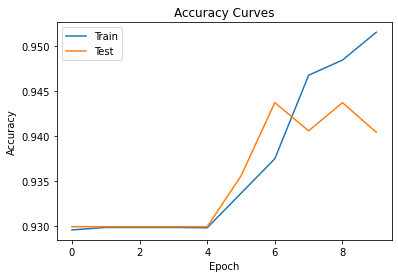

In [81]:
plt.plot(trained.history['accuracy'])
plt.plot(trained.history['val_accuracy'])
plt.title('Accuracy Curves')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

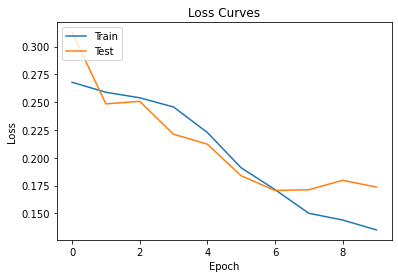

In [82]:
plt.plot(trained.history['loss'])
plt.plot(trained.history['val_loss'])
plt.title('Loss Curves')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

# CNN

In [83]:
from keras.layers import Embedding, Conv1D, MaxPooling1D, Flatten, Dense
from tensorflow.keras.optimizers import Adam, SGD
def build_cnn_model():
    model = Sequential()
    
    model.add(Embedding(5000, 100, input_length=100))


    model.add(Conv1D(64, 2, padding='same', activation='relu'))
    model.add(MaxPooling1D(2))
    #model.add(MaxPooling1D(2))
    
    model.add(Flatten())
    
    model.add(Dense(units=1024,activation="relu"))
    model.add(Dense(units=512,activation="relu"))
    
    model.add(Dense(units=num_classes,activation="softmax"))
    
    optimizer = Adam(lr=0.000055,beta_1=0.9,beta_2=0.999)
    
    model.compile(optimizer=optimizer,metrics=["accuracy"],loss=tf.keras.losses.SparseCategoricalCrossentropy())
    return model

In [84]:
cnn_model = build_cnn_model()

In [85]:
cnn_history = cnn_model.fit(X_train, y_train,
                    epochs=10, 
                    validation_data=(X_val, y_val),
                    shuffle=True)

Epoch 1/10
800/800 [==============================] - 31s 39ms/step - loss: 0.2574 - accuracy: 0.9288 - val_loss: 0.2332 - val_accuracy: 0.9299
Epoch 2/10
800/800 [==============================] - 31s 39ms/step - loss: 0.1719 - accuracy: 0.9420 - val_loss: 0.1620 - val_accuracy: 0.9478
Epoch 3/10
800/800 [==============================] - 31s 39ms/step - loss: 0.1150 - accuracy: 0.9601 - val_loss: 0.1575 - val_accuracy: 0.9498
Epoch 4/10
800/800 [==============================] - 31s 39ms/step - loss: 0.0869 - accuracy: 0.9709 - val_loss: 0.1605 - val_accuracy: 0.9520
Epoch 5/10
800/800 [==============================] - 32s 41ms/step - loss: 0.0668 - accuracy: 0.9787 - val_loss: 0.1763 - val_accuracy: 0.9515
Epoch 6/10
800/800 [==============================] - 33s 41ms/step - loss: 0.0498 - accuracy: 0.9846 - val_loss: 0.1917 - val_accuracy: 0.9517
Epoch 7/10
800/800 [==============================] - 31s 39ms/step - loss: 0.0366 - accuracy: 0.9892 - val_loss: 0.2020 - val_accuracy:

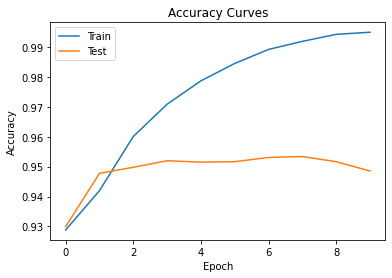

In [86]:
plt.plot(cnn_history.history['accuracy'])
plt.plot(cnn_history.history['val_accuracy'])
plt.title('Accuracy Curves')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

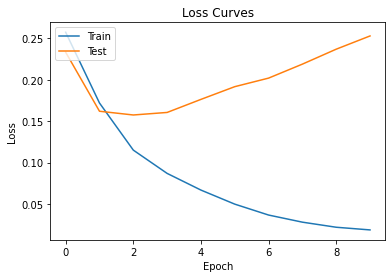

In [87]:
plt.plot(cnn_history.history['loss'])
plt.plot(cnn_history.history['val_loss'])
plt.title('Loss Curves')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

# Machine Learning

In [88]:
import numpy as np
import re
import nltk
import pickle
from nltk.corpus import stopwords
import pandas as pd 
import warnings

In [89]:
df= pd.read_csv("train.csv")

In [90]:
df = df.dropna(how = 'any')

In [91]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 31962 entries, 0 to 31961
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      31962 non-null  int64 
 1   label   31962 non-null  int64 
 2   tweet   31962 non-null  object
dtypes: int64(2), object(1)
memory usage: 998.8+ KB


In [92]:
#df['label'] = df['Text Label'].map({'Non-Bullying': 0, 'Bullying': 1})
df['message'] = df['tweet']
#df.drop(['Text Label','Tweet'],axis=1,inplace=True)

In [93]:
X = df['message']
y = df['label']

In [94]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split

In [95]:
cv = CountVectorizer()
X = cv.fit_transform(X) # Fit the Data

In [96]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

In [97]:
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import warnings

# Logistic Regression

In [98]:
from sklearn.linear_model import LogisticRegression
LogisticR = LogisticRegression()
LogisticR.fit(X_train, y_train) 
y_pred = LogisticR.predict(X_test)
print(confusion_matrix(y_test,y_pred))
print(classification_report(y_test,y_pred))
print(accuracy_score(y_test, y_pred))
LR = accuracy_score(y_test, y_pred)

[[9735   71]
 [ 366  376]]
              precision    recall  f1-score   support

           0       0.96      0.99      0.98      9806
           1       0.84      0.51      0.63       742

    accuracy                           0.96     10548
   macro avg       0.90      0.75      0.81     10548
weighted avg       0.96      0.96      0.95     10548

0.9585703450891164


C:\Users\Tru Projects\AppData\Roaming\Python\Python38\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


# Random Forest

In [99]:
from sklearn.ensemble import RandomForestClassifier
RandomForest = RandomForestClassifier(n_estimators=10, random_state=0)
RandomForest.fit(X_train, y_train) 
print(confusion_matrix(y_test,y_pred))
print(classification_report(y_test,y_pred))
print(accuracy_score(y_test, y_pred))
RF = accuracy_score(y_test, y_pred)

[[9735   71]
 [ 366  376]]
              precision    recall  f1-score   support

           0       0.96      0.99      0.98      9806
           1       0.84      0.51      0.63       742

    accuracy                           0.96     10548
   macro avg       0.90      0.75      0.81     10548
weighted avg       0.96      0.96      0.95     10548

0.9585703450891164


# KNN

In [100]:
from sklearn.neighbors import KNeighborsClassifier
KNN = KNeighborsClassifier(n_neighbors=3)
KNN.fit(X_train, y_train)
y_pred = KNN.predict(X_test)
print(confusion_matrix(y_test,y_pred))
print(classification_report(y_test,y_pred))
print(accuracy_score(y_test, y_pred))
KNNA = accuracy_score(y_test, y_pred)

[[9753   53]
 [ 586  156]]
              precision    recall  f1-score   support

           0       0.94      0.99      0.97      9806
           1       0.75      0.21      0.33       742

    accuracy                           0.94     10548
   macro avg       0.84      0.60      0.65     10548
weighted avg       0.93      0.94      0.92     10548

0.939419795221843


# Decision Tree

In [101]:
from sklearn.tree import DecisionTreeClassifier
DecisionTree = DecisionTreeClassifier()
DecisionTree.fit(X_train, y_train)
y_pred = DecisionTree.predict(X_test)
print(confusion_matrix(y_test,y_pred))
print(classification_report(y_test,y_pred))
print(accuracy_score(y_test, y_pred))
DT = accuracy_score(y_test, y_pred)

[[9603  203]
 [ 350  392]]
              precision    recall  f1-score   support

           0       0.96      0.98      0.97      9806
           1       0.66      0.53      0.59       742

    accuracy                           0.95     10548
   macro avg       0.81      0.75      0.78     10548
weighted avg       0.94      0.95      0.94     10548

0.9475729996207812


# SVM

In [102]:
from sklearn.svm import SVC
svm = SVC(gamma='auto')
svm.fit(X_train, y_train)
y_pred = svm.predict(X_test)
print(confusion_matrix(y_test,y_pred))
print(classification_report(y_test,y_pred))
print(accuracy_score(y_test, y_pred))
svm = accuracy_score(y_test, y_pred)

[[9806    0]
 [ 742    0]]
              precision    recall  f1-score   support

           0       0.93      1.00      0.96      9806
           1       0.00      0.00      0.00       742

    accuracy                           0.93     10548
   macro avg       0.46      0.50      0.48     10548
weighted avg       0.86      0.93      0.90     10548

0.9296549108835799


C:\Users\Tru Projects\AppData\Roaming\Python\Python38\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


# Voting Classifier

In [103]:
from sklearn.ensemble import VotingClassifier
from sklearn.neural_network import MLPClassifier
from sklearn import model_selection
from sklearn.svm import SVC
seed = 7
kfold = model_selection.KFold(n_splits=10, random_state=seed)
estimators = []
model1 = LogisticRegression()
estimators.append(('logistic', model1))
model2 = RandomForestClassifier()
estimators.append(('cart', model2))
model3 = SVC()
estimators.append(('svm', model3))

# create the ensemble model
ensemble = VotingClassifier(estimators)
warnings.simplefilter("ignore")

print(ensemble)
ensemble.fit(X_train, y_train)

y_pred = ensemble.predict(X_test)
print(confusion_matrix(y_test,y_pred))
print(classification_report(y_test,y_pred))
print(accuracy_score(y_test, y_pred))

E= accuracy_score(y_test, y_pred)

C:\Users\Tru Projects\AppData\Roaming\Python\Python38\site-packages\sklearn\model_selection\_split.py:293: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  warnings.warn(


VotingClassifier(estimators=[('logistic', LogisticRegression()),
                             ('cart', RandomForestClassifier()),
                             ('svm', SVC())])
[[9791   15]
 [ 438  304]]
              precision    recall  f1-score   support

           0       0.96      1.00      0.98      9806
           1       0.95      0.41      0.57       742

    accuracy                           0.96     10548
   macro avg       0.96      0.70      0.78     10548
weighted avg       0.96      0.96      0.95     10548

0.9570534698521047
